In [1]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# **Data Collection**

In [2]:
nasdaq = yf.Ticker("^IXIC")
nasdaq = nasdaq.history(period="max")

In [3]:
nasdaq

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1971-02-05 00:00:00-05:00,100.000000,100.000000,100.000000,100.000000,0,0.0,0.0
1971-02-08 00:00:00-05:00,100.839996,100.839996,100.839996,100.839996,0,0.0,0.0
1971-02-09 00:00:00-05:00,100.760002,100.760002,100.760002,100.760002,0,0.0,0.0
1971-02-10 00:00:00-05:00,100.690002,100.690002,100.690002,100.690002,0,0.0,0.0
1971-02-11 00:00:00-05:00,101.449997,101.449997,101.449997,101.449997,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-02 00:00:00-04:00,15758.110352,15862.790039,15604.730469,15840.959961,4901610000,0.0,0.0
2024-05-03 00:00:00-04:00,16147.480469,16204.709961,16068.339844,16156.330078,4887310000,0.0,0.0
2024-05-06 00:00:00-04:00,16208.540039,16350.080078,16197.860352,16349.250000,4460130000,0.0,0.0


In [4]:
nasdaq = nasdaq.loc["2000-01-01":].copy()

# **Data Preprocessing **

In [5]:
del nasdaq["Dividends"]
del nasdaq["Stock Splits"]

In [6]:
nasdaq

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03 00:00:00-05:00,4186.189941,4192.189941,3989.709961,4131.149902,1510070000
2000-01-04 00:00:00-05:00,4020.000000,4073.250000,3898.229980,3901.689941,1511840000
2000-01-05 00:00:00-05:00,3854.350098,3924.209961,3734.870117,3877.540039,1735670000
2000-01-06 00:00:00-05:00,3834.439941,3868.760010,3715.620117,3727.129883,1598320000
2000-01-07 00:00:00-05:00,3711.090088,3882.669922,3711.090088,3882.620117,1634930000
...,...,...,...,...,...
2024-05-02 00:00:00-04:00,15758.110352,15862.790039,15604.730469,15840.959961,4901610000
2024-05-03 00:00:00-04:00,16147.480469,16204.709961,16068.339844,16156.330078,4887310000
2024-05-06 00:00:00-04:00,16208.540039,16350.080078,16197.860352,16349.250000,4460130000


In [7]:
nasdaq["Tomorrow"] = nasdaq["Open"].shift(-1)
nasdaq["Target"] = (nasdaq["Tomorrow"] > nasdaq["Open"]).astype(int)

In [8]:
nasdaq

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2000-01-03 00:00:00-05:00,4186.189941,4192.189941,3989.709961,4131.149902,1510070000,4020.000000,0
2000-01-04 00:00:00-05:00,4020.000000,4073.250000,3898.229980,3901.689941,1511840000,3854.350098,0
2000-01-05 00:00:00-05:00,3854.350098,3924.209961,3734.870117,3877.540039,1735670000,3834.439941,0
2000-01-06 00:00:00-05:00,3834.439941,3868.760010,3715.620117,3727.129883,1598320000,3711.090088,0
2000-01-07 00:00:00-05:00,3711.090088,3882.669922,3711.090088,3882.620117,1634930000,4002.229980,1
...,...,...,...,...,...,...,...
2024-05-02 00:00:00-04:00,15758.110352,15862.790039,15604.730469,15840.959961,4901610000,16147.480469,1
2024-05-03 00:00:00-04:00,16147.480469,16204.709961,16068.339844,16156.330078,4887310000,16208.540039,1
2024-05-06 00:00:00-04:00,16208.540039,16350.080078,16197.860352,16349.250000,4460130000,16358.339844,1


In [9]:
# Additional Predictors
nasdaq["Open_Ratio_2"] = nasdaq["Open"] / nasdaq["Open"].rolling(window=2).mean()
nasdaq["Open_Ratio_5"] = nasdaq["Open"] / nasdaq["Open"].rolling(window=5).mean()
nasdaq["Open_Ratio_60"] = nasdaq["Open"] / nasdaq["Open"].rolling(window=60).mean()
nasdaq["Open_Ratio_250"] = nasdaq["Open"] / nasdaq["Open"].rolling(window=250).mean()
nasdaq["Open_Ratio_1000"] = nasdaq["Open"] / nasdaq["Open"].rolling(window=1000).mean()

for horizon in [2, 5, 60, 250, 1000]:
    nasdaq[f"Trend_{horizon}"] = nasdaq["Target"].rolling(window=horizon).sum()

# **Training the model**

In [10]:

# Model Training and Evaluation
predictors = ["Close", "Open", "Low", "High", "Volume",
              "Open_Ratio_2", "Open_Ratio_5", "Open_Ratio_60", "Open_Ratio_250", "Open_Ratio_1000",
              "Trend_2", "Trend_5", "Trend_60", "Trend_250", "Trend_1000"]

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=1)
}

backtest_results = {}

Training and evaluating Random Forest...


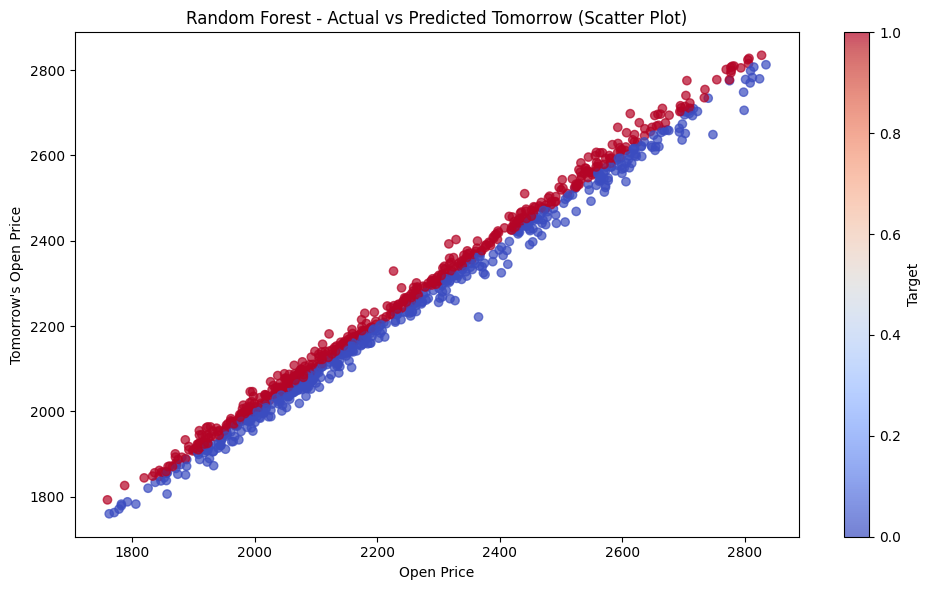

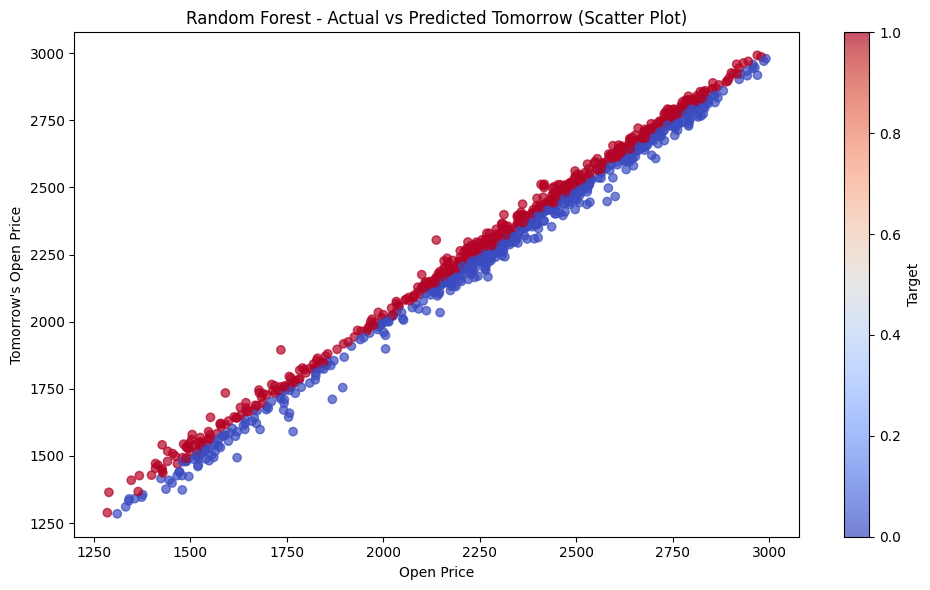

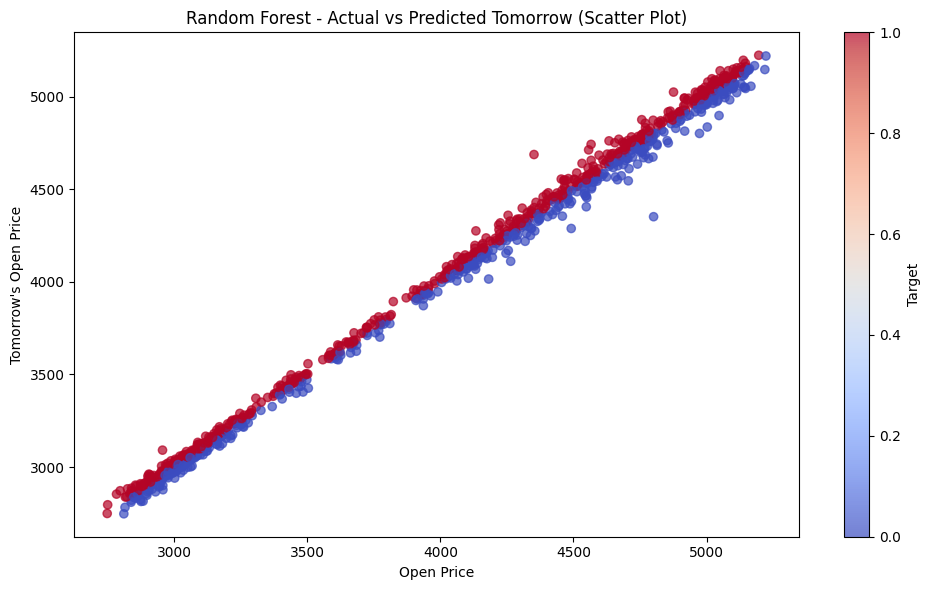

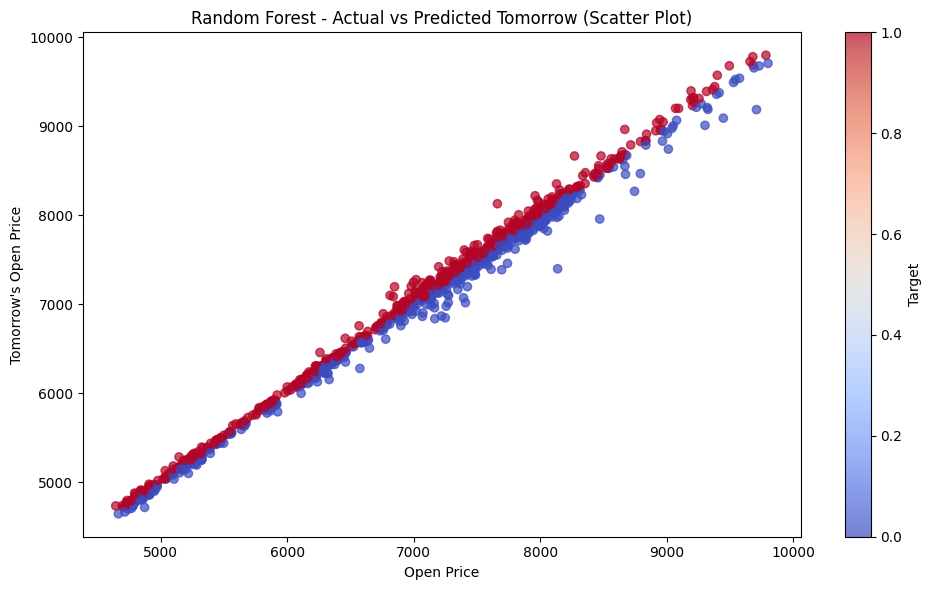

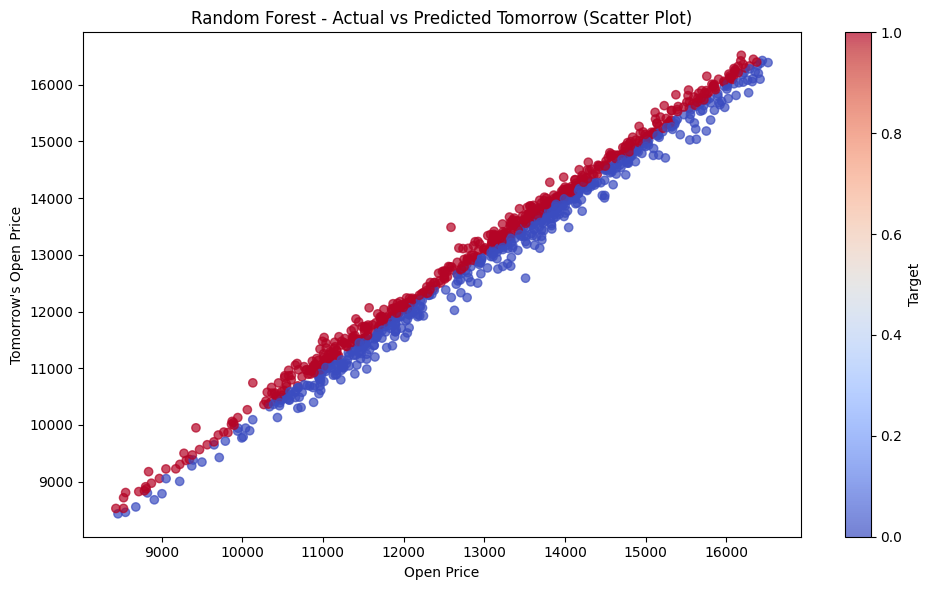

Training and evaluating XGBoost...


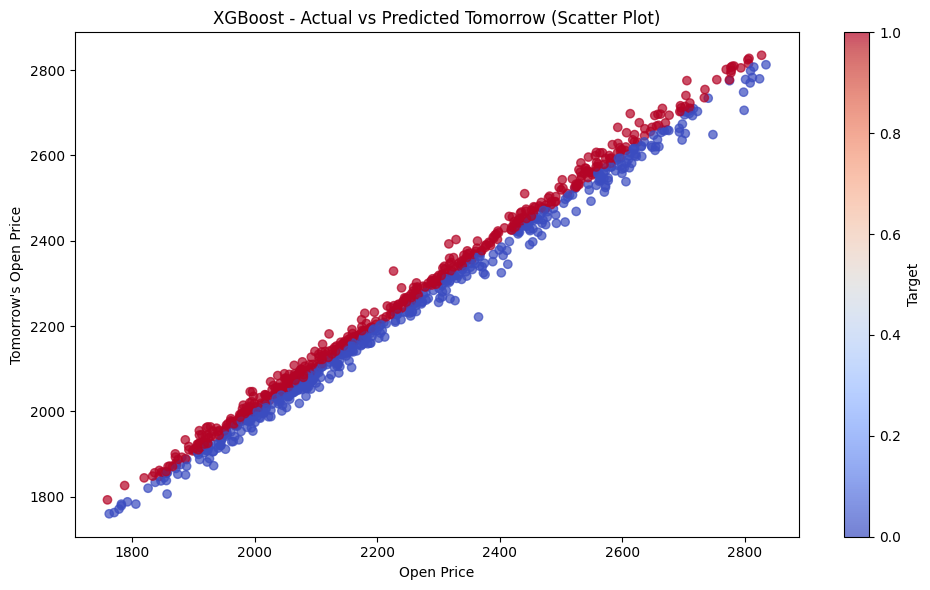

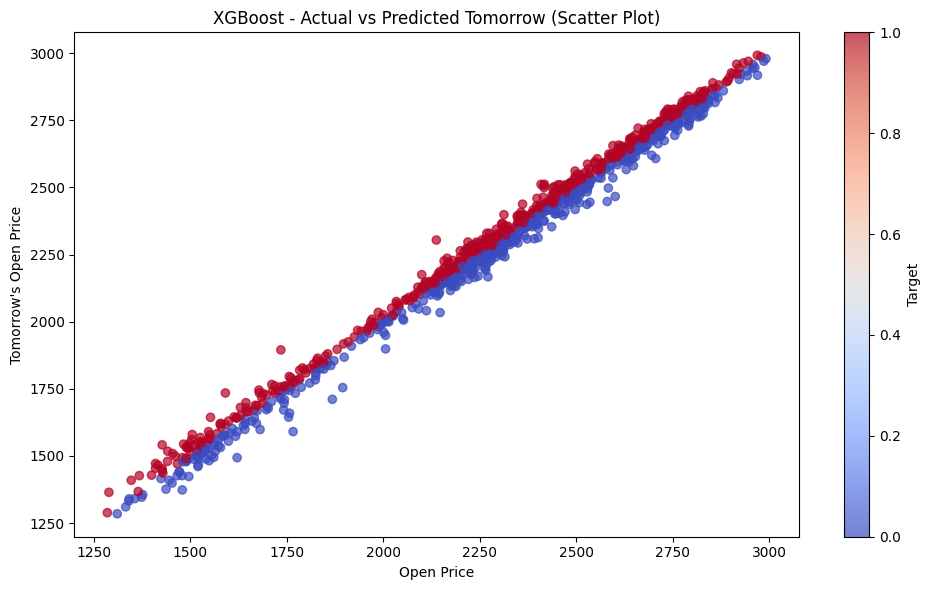

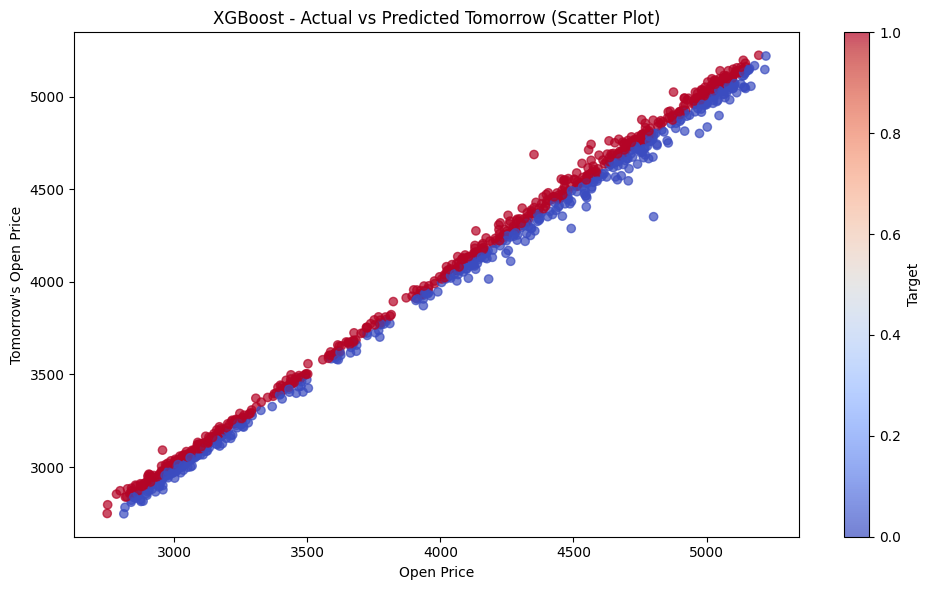

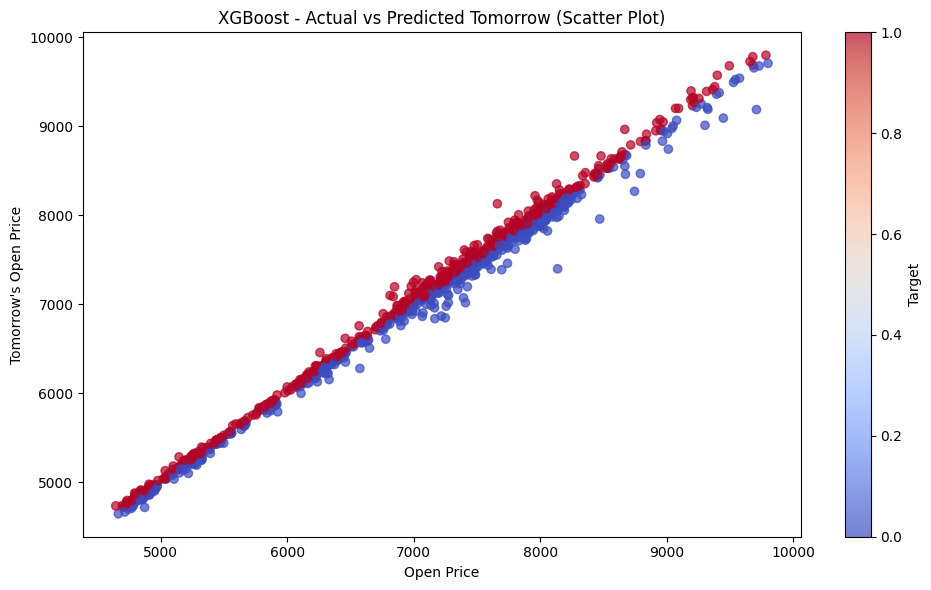

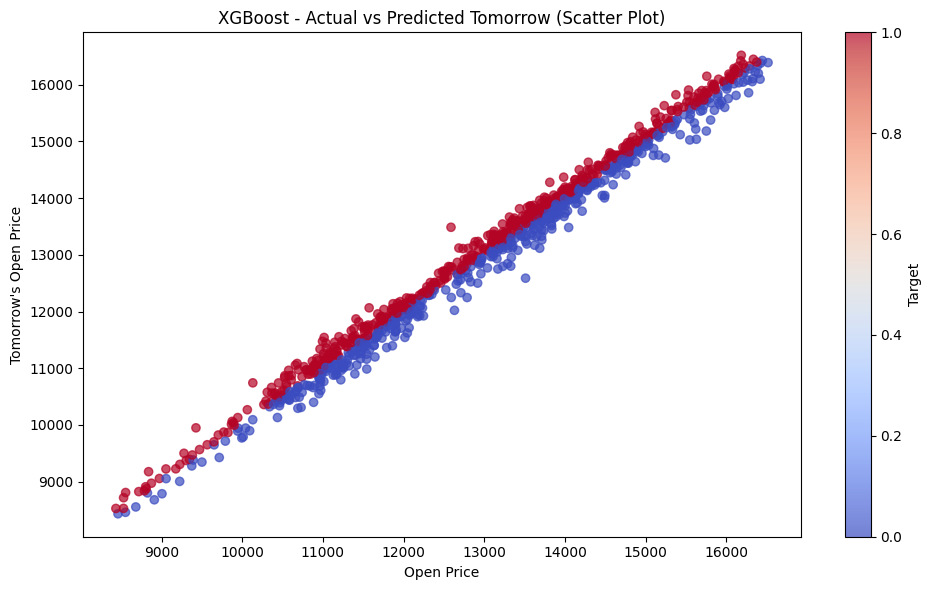

In [11]:
# Train and evaluate models
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    precision_scores = []
    accuracy_scores = []
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(nasdaq):
        train = nasdaq.iloc[train_index]
        test = nasdaq.iloc[test_index]

        # Handle missing values using an imputer
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values using mean
            ('clf', model)
        ])

        pipeline.fit(train[predictors], train["Target"])
        preds = pipeline.predict(test[predictors])

        precision = precision_score(test["Target"], preds)
        accuracy = accuracy_score(test["Target"], preds)

        precision_scores.append(precision)
        accuracy_scores.append(accuracy)

        # Scatter Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(test["Open"], test["Tomorrow"], c=test["Target"], cmap='coolwarm', alpha=0.7)
        plt.title(f"{model_name} - Actual vs Predicted Tomorrow (Scatter Plot)")
        plt.xlabel("Open Price")
        plt.ylabel("Tomorrow's Open Price")
        plt.colorbar(label="Target")
        plt.tight_layout()
        plt.show()

    backtest_results[model_name] = {"Precision": precision_scores, "Accuracy": accuracy_scores}

# **Random Forest Classifiers**

In [12]:
# Print precision and accuracy scores
for model_name, scores in backtest_results.items():
    print(f"{model_name} Precision Scores:", scores["Precision"])
    print(f"{model_name} Accuracy Scores:", scores["Accuracy"])

Random Forest Precision Scores: [1.0, 1.0, 1.0, 1.0, 1.0]
Random Forest Accuracy Scores: [0.990205680705191, 0.9970617042115573, 0.9990205680705191, 0.9951028403525954, 0.9941234084231146]
XGBoost Precision Scores: [0.9981851179673321, 1.0, 1.0, 1.0, 1.0]
XGBoost Accuracy Scores: [0.9970617042115573, 1.0, 1.0, 1.0, 1.0]


# **Gradient Boosting Classifiers**

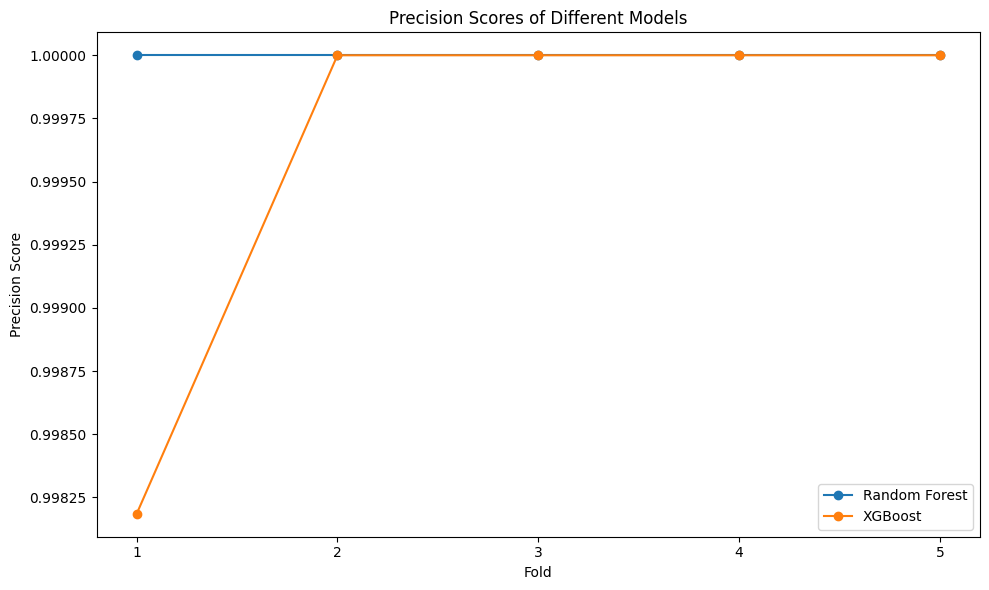

In [13]:
# Visualization
plt.figure(figsize=(10, 6))
for model_name, scores in backtest_results.items():
    plt.plot(range(1, len(scores["Precision"]) + 1), scores["Precision"], marker='o', label=model_name)

plt.title("Precision Scores of Different Models")
plt.xlabel("Fold")
plt.ylabel("Precision Score")
plt.legend()
plt.xticks(range(1, 6))
plt.tight_layout()
plt.show()